# Neural ODE from Scratch
In this problem we will work through the development of a neural ODE.

### Part 1: Gradients as vjps
Use the definition of the pullback as a vector-Jacobian product (vjp) to show that $B_f^{x}(1) = (\nabla f(x))^{T}$ for a function $f: \mathbb{R}^n \rightarrow \mathbb{R}$.

sol:  

$f: \mathbb{R}^n \rightarrow \mathbb{R}$ is a scalar function.  
Let $f(x_1, \dots, x_n)=y$ and let $L(y)$ be the scalar loss function.  
Using the notation from lecture, we denote $\bar{y} = \frac{\partial{L}}{\partial{y}} \in \mathbb{R}$.  
By the definition of pullback,  
$$B_f^{x}(\bar{y}) = 
\begin{bmatrix}
\bar{x_1} \\ \bar{x_2} \\ \vdots \\ \bar{x_n}
\end{bmatrix}, where \;  \bar{x_i} = \frac{\partial{L}}{\partial{x_i}} = \frac{\partial{L}}{\partial{y}} \frac{\partial{y}}{\partial{x_i}} = \bar{y} \frac{\partial{y}}{\partial{x_i}} = \bar{y} \frac{\partial{f(x_1, \dots, x_n)}}{\partial{x_i}}$$  
$$\implies B_f^{x}(\bar{y}) = 
\begin{bmatrix}
\bar{x_1} \\ \vdots \\ \bar{x_n}
\end{bmatrix} = 
\begin{bmatrix}
\bar{y} \frac{\partial{f(x_1, \dots, x_n)}}{\partial{x_1}} \\  \vdots \\ \bar{y} \frac{\partial{f(x_1, \dots, x_n)}}{\partial{x_n}}
\end{bmatrix} \in \mathbb{R}^n$$

Plug in 1 into $\bar{y}$, we get 
$$ B_f^{x}(1) = \begin{bmatrix}
 \frac{\partial{f(x_1, \dots, x_n)}}{\partial{x_1}} \\  \vdots \\ \frac{\partial{f(x_1, \dots, x_n)}}{\partial{x_n}}
\end{bmatrix}
$$

Since we know that the gradient of $f$ at $x$ is $\nabla f(x) = \begin{bmatrix}
 \frac{\partial{f}}{\partial{x_1}} \\  \vdots \\ \frac{\partial{f}}{\partial{x_n}}
\end{bmatrix}$, and the Jacobian of $f$ at $x$ is $\begin{bmatrix}
 \frac{\partial{f}}{\partial{x_1}}   \dots  \frac{\partial{f}}{\partial{x_n}}
\end{bmatrix}$  

$\implies B_f^{x}(1) = $ the gradient of $f$ at $x$ (i.e. $\nabla f(x)$) = the transpose of the Jacobian of $f$ at $x$

### Part 2: Backpropagation of a neural network

In [28]:
using ForwardDiff
using DifferentialEquations
using Plots

In [29]:
# Part 2
function NN(u, W1, W2, b1, b2)
    return W2*(tanh.(W1*u+b1))+b2
end

function pullback(y, u, W1, W2, b1, b2)
    z = W1*u+b1
    x = tanh.(z)
    W2_bar = y * transpose(x)
    b2_bar = y
    x_bar = transpose(W2) * y
    z_bar = x_bar .* (1 .- (tanh.(z)).^2)
    W1_bar = z_bar * transpose(u)
    b1_bar = z_bar
    u_bar = transpose(W1) * z_bar
    return u_bar, W1_bar, W2_bar, b1_bar, b2_bar
end

# use the function
u = rand(Float64, (2,1))
W1 = rand(Float64, (50,2))
W2 = rand(Float64, (2,50))
b1 = rand(Float64, (50,1))
b2 = rand(Float64, (2,1))
pullback_10 = pullback([1,0], u, W1, W2, b1, b2)
pullback_01 = pullback([0,1], u, W1, W2, b1, b2)

([6.9224042321115915; 6.884206726782781;;], [0.1830325788047039 0.23270419248666563; 0.06720505850659943 0.0854432526325495; … ; 0.062444415089363464 0.07939065975886822; 0.004821557031621406 0.00613003730209711], [0.0 0.0 … 0.0 0.0; 0.2048659237145907 0.7232432446524031 … 0.5917208621560677 0.2516023808437754], [0.897720395048129; 0.3296208361690119; … ; 0.30627129524512847; 0.023648304096685835;;], [0, 1])

In [30]:
# check the correctness by using ForwardDiff.jl

# check u_bar
print("u_bar: ")
println(transpose([vec(pullback_10[1]) vec(pullback_01[1])]) ≈ ForwardDiff.jacobian(u -> NN(u, W1, W2, b1, b2), u))
# check W1_bar
print("W1_bar: ")
println(transpose([vec(pullback_10[2]) vec(pullback_01[2])]) ≈ ForwardDiff.jacobian(W1 -> NN(u, W1, W2, b1, b2), W1))
# check W2_bar
print("W2_bar: ")
println(transpose([vec(pullback_10[3]) vec(pullback_01[3])]) ≈ ForwardDiff.jacobian(W2 -> NN(u, W1, W2, b1, b2), W2))
# check b1_bar
print("b1_bar: ")
println(transpose([vec(pullback_10[4])  vec(pullback_01[4])]) ≈ ForwardDiff.jacobian(b1 -> NN(u, W1, W2, b1, b2), b1))
# check b2_bar
print("b2_bar: ")
println(transpose([vec(pullback_10[5])  vec(pullback_01[5])]) ≈ ForwardDiff.jacobian(b2 -> NN(u, W1, W2, b1, b2), b2))

u_bar: true
W1_bar: true
W2_bar: true
b1_bar: true
b2_bar: true


### Part 3 & Part 4: Implementing an ODE adjoint/Training the neural ODE

In [31]:
# Part 3 and Part 4
function flatten(u, W1, W2, b1, b2) # u:2*1, W1:50*2, W2:2*50, b1:50*1, b2:2*1
    return vcat(vec(u), vec(W1), vec(W2), vec(b1), vec(b2))
end

function unflatten(param)
    u = reshape(param[1:2], (2,1))
    W1 = reshape(param[3:102], (50,2))
    W2 = reshape(param[103:202], (2,50))
    b1 = reshape(param[203:252], (50,1))
    b2 = reshape(param[253:254], (2,1))
    return u, W1, W2, b1, b2
end

# forward ODE: u' = NN(u)
function NN3(du,u,p,t) #p[1]=W1, p[2]=W2, p[3]=b1, p[4]=b2
    du[:] = p[2]*(tanh.(p[1]*u[:]+p[3]))+p[4]
end

# backward ODE: solve lambda and mu
function ODEpullback(du,u,p,t) #p[1]=W1, p[2]=W2, p[3]=b1, p[4]=b2
    #du[:] = -flatten(pullback(y,u,W1,W2,b1,b2))
    #du[:] = -flatten(pullback(u[1:2],sol_forward(t),p[1],p[2],p[3],p[4]))
    bars = pullback(u[1:2],sol_forward(t),p[1],p[2],p[3],p[4])
    du[:] = -flatten(bars[1], bars[2], bars[3], bars[4], bars[5])
end

ODEpullback (generic function with 1 method)

In [32]:
# exact solution ODE: u' = Au
function ODE_A(du,u,p,t)
    du[:] = p*u
end

# generate exact solution
u0 = [2,0]
tspan = (0.0,1.0)
A = [-0.1 2.0; -2.0 -0.1]
p = A
prob_A = ODEProblem(ODE_A,u0,tspan,p)
sol_A = solve(prob_A, saveat = 0.1, Tsit5())
plot(sol_A)
exact_sol = sol_A.u  # t = 0, 0.1, 0.2, ..., 0.9, 1 (11 in total)

11-element Vector{Vector{Float64}}:
 [2.0, 0.0]
 [1.9406295032913505, -0.39338507953911794]
 [1.805645530137743, -0.7634146819420129]
 [1.6018867750100534, -1.095909843630588]
 [1.338776071153181, -1.3784580407897982]
 [1.0279034459439917, -1.600864573055554]
 [0.6825080332437764, -1.7555263033275166]
 [0.31695296026519104, -1.8376574111530912]
 [-0.05391453072152477, -1.8454461826938846]
 [-0.41529840433519183, -1.780065185188405]
 [-0.7530931011216518, -1.6455297727178742]

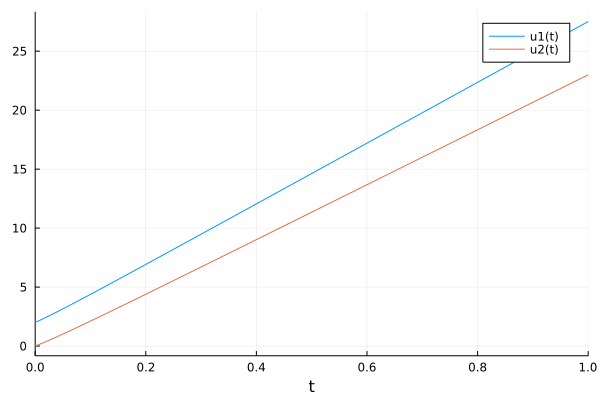

In [33]:
# solve forward for the first time (with random initial paramter)
u0 = [2,0]
tspan = (0.0,1.0)
W1 = rand(Float64, (50,2))
W2 = rand(Float64, (2,50))
b1 = rand(Float64, (50,1))
b2 = rand(Float64, (2,1))
p = (W1, W2, b1, b2)
prob = ODEProblem(NN3,u0,tspan,p)
sol_forward = solve(prob, Tsit5())
plot(sol_forward)

In [34]:
# define loss function
function cal_loss(sol_forward, exact_sol)
    difference = sol_forward(0:0.1:1).u - exact_sol
    loss = 0
    for i in 1:11
        loss = loss + sum(difference[i] .^ 2)
    end
    return loss
end

# gradient descent 
loss = cal_loss(sol_forward, exact_sol)
iter = 0
loss_vec = zeros(0) 
append!(loss_vec, loss) 

#for epoch in 1:10000
while loss > sqrt(eps()) && iter < 100000
    #print(iter)
    # get dC_du
    dC_du = 2 * (sol_forward(0:0.1:1).u - exact_sol)

    # solve backward
    dosetimes = 0.9:(-0.1):0 #0:0.1:0.9
    condition(u,t,integrator) = t ∈ dosetimes # t=0.9, 0.8, ..., 0
    affect!(integrator) = integrator.u[1:2] += dC_du[Int(round((integrator.t+0.1)*10))]
    cb = DiscreteCallback(condition,affect!)
    
    u0_lambda = dC_du[11]
    u0_mu = zeros(252,1)
    u0 = vec(vcat(u0_lambda, u0_mu))
    tspan = (1.0,0.0)
    p = (W1, W2, b1, b2)
    
    prob_backward = ODEProblem(ODEpullback,u0,tspan,p)
    sol_backward = solve(prob_backward,Tsit5(),callback=cb,tstops=dosetimes)
    #plot(sol_backward)

    dC_dp_u, dC_dp_W1, dC_dp_W2, dC_dp_b1, dC_dp_b2 = unflatten(sol_backward(0))
    
    rate = 0.001
    W1 = W1 - rate * dC_dp_W1
    W2 = W2 - rate * dC_dp_W2
    b1 = b1 - rate * dC_dp_b1
    b2 = b2 - rate * dC_dp_b2

    # solve forward with the updated parameters
    u0 = [2,0]
    tspan = (0.0,1.0)
    p = (W1, W2, b1, b2)
    prob = ODEProblem(NN3,u0,tspan,p)
    sol_forward = solve(prob, Tsit5())
    
    # calculate loss
    loss = cal_loss(sol_forward, exact_sol)
    append!(loss_vec, loss) 
    iter = iter + 1 
end 

The number of iterations is 100000
The loss in the last epoch is 8.424941883853764e-5

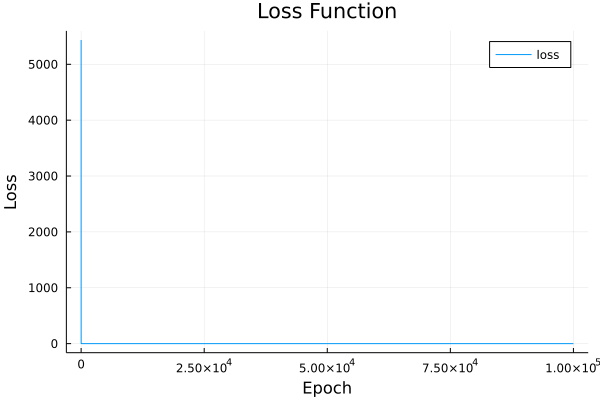

In [35]:
# plot the loss vector
print("The number of iterations is ")
println(iter)
print("The loss in the last epoch is ")
print(loss_vec[end])
plot(1:length(loss_vec),[loss_vec],labels="loss")
xlabel!("Epoch")
ylabel!("Loss")
title!("Loss Function")

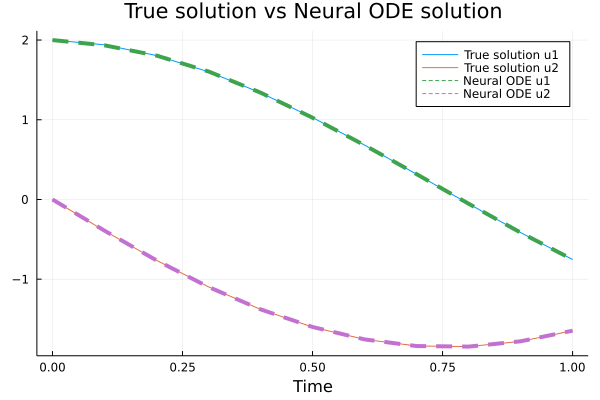

In [36]:
# plot the exact solution and the solution got from Neural ODE
sol_hat = sol_forward(0:0.1:1).u
u1_hat = zeros(0)
u2_hat = zeros(0)
for i in 1:11
    append!(u1_hat, sol_hat[i][1])
    append!(u2_hat, sol_hat[i][2])
end

#plot(0:0.1:1, [sol_A[1,:], sol_A[2,:]])
#plot(0:0.1:1, [u1_hat, u2_hat])
plot(0:0.1:1, [sol_A[1,:], sol_A[2,:],u1_hat, u2_hat],labels=["True solution u1" "True solution u2" "Neural ODE u1" "Neural ODE u2"], 
ls=[:solid :solid :dash :dash], lw=[1 1 4 4])
xlabel!("Time")
title!("True solution vs Neural ODE solution")

From the plot, we can see that the solution we get from neural ODE is almost the same as the true solution.

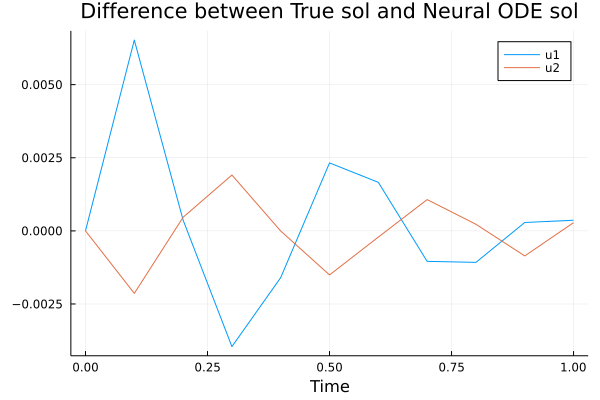

In [38]:
# plot the difference between NN solution and exact solution
plot(0:0.1:1, [sol_A[1,:]-u1_hat, sol_A[2,:]-u2_hat],labels=["u1" "u2"])
xlabel!("Time")
title!("Difference between True sol and Neural ODE sol")

The difference between the true solution and the neural ODE is very small, below 0.01.

In [39]:
# print the final W1, W2, b1, b2
println("W1: ")
println(W1)
println("W2: ")
println(W2)
println("b1: ")
println(b1)
println("b2: ")
println(b2)

W1: 
[0.0913937279965147 0.45364579734321847; 0.03849308831818126 0.6429170591985247; 0.4197218297250193 0.20580171977939993; 0.21268003232868898 0.42505887227471995; 0.8843915794300383 0.5546053872263589; 0.5353974864043446 0.3645596826112017; 0.6111754143422677 0.427161765367604; 1.0381031464378632 0.20616960275060806; 0.9718016334547402 0.7419839637255699; -0.5601694391360845 -0.16292624588089083; 0.7531477608366757 0.8473618243587556; 0.10244804942635875 0.3044500951533212; 0.5307226986091153 0.033048897822514064; 0.34378078561644115 0.2977743811655513; 0.32844798581778556 0.49871271625411345; 0.4507757381815403 0.8853018873698639; 0.8607574327619519 0.298999863048587; 0.6808272579698357 0.8673195114411802; 0.635383589348859 0.9685585382681263; -0.6369860304512396 0.31744197801737123; 0.507427291773067 0.7639770859705464; 0.7746180617752131 0.8571886070197058; 0.250302173253342 0.4235236122076231; 0.21973048335249795 0.16040115092134016; 0.4090169381848003 0.874845335775488; 0.6786